# Preprocessing danych

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_frame = pd.read_csv('../Data/Raw_data_2023.csv', encoding='unicode_escape', sep=",")
data_frame.dtypes

Month                               object
Day                                  int64
Week day                            object
Hour                                 int64
Dry-Bulb Temp (°C)                 float64
Heating Load (kW)                  float64
Chiller Output (kW)                float64
Chiller Input (kW)                 float64
Total Building Electric [kW]       float64
Precool Coil Load (kW)             float64
Preheat Coil Load (kW)             float64
Terminal Cooling Coil Load (kW)    float64
Terminal Heating Coil Load (kW)    float64
Ventilation Fan (kW)               float64
Exhaust Fan (kW)                   float64
Terminal Fan (kW)                  float64
Vent. Reclaim Device (kW)          float64
Lighting (kW)                      float64
Electric Equipment (kW)            float64
dtype: object

In [3]:
base_df = data_frame[['Hour','Dry-Bulb Temp (°C)']]
base_df

,Hour,Dry-Bulb Temp (°C)
0,0,-4.3
1,1,-4.1
2,2,-4.0
3,3,-3.8
4,4,-3.5
...,...,...
8755,19,0.2
8756,20,0.3
8757,21,0.3
8758,22,0.3


In [4]:
month_df= data_frame['Month'].values
month_df

array(['Jan', 'Jan', 'Jan', ..., 'Dec', 'Dec', 'Dec'], dtype=object)

In [5]:
month_encoded = pd.get_dummies(month_df, columns = ['Month'])
month_encoded

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,False,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,False,False,True,False,False,False,False,False,False,False,False,False
8756,False,False,True,False,False,False,False,False,False,False,False,False
8757,False,False,True,False,False,False,False,False,False,False,False,False
8758,False,False,True,False,False,False,False,False,False,False,False,False


In [6]:
weekday_df = data_frame['Week day'].values
weekday_df

array(['Sunday', 'Sunday', 'Sunday', ..., 'Sunday', 'Sunday', 'Sunday'],
      dtype=object)

In [7]:
weekday_encoded = pd.get_dummies(weekday_df, columns = ['Week day'])
weekday_encoded

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,False,False,False,True,False,False,False
1,False,False,False,True,False,False,False
2,False,False,False,True,False,False,False
3,False,False,False,True,False,False,False
4,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...
8755,False,False,False,True,False,False,False
8756,False,False,False,True,False,False,False
8757,False,False,False,True,False,False,False
8758,False,False,False,True,False,False,False


In [8]:
X_train = np.concatenate((base_df, month_encoded, weekday_encoded), axis=1)
print(X_train.shape)

(8760, 21)


In [9]:
y_train= data_frame['Heating Load (kW)'].values
y_train

array([222.6, 224.1, 225.4, ..., 179.8, 181.9, 184.2])

In [10]:
data_frame_2024 = pd.read_csv('../Data/Raw_data_2024.csv', encoding='unicode_escape', sep=",")
data_frame_2024.dtypes
base_2024_df = data_frame_2024[['Hour','Dry-Bulb Temp (°C)']]
month_2024_df = data_frame_2024['Month'].values
month_2024_encoded = pd.get_dummies(month_2024_df, columns = ['Month'])
weekday_2024_df = data_frame_2024['Week day'].values
weekday_2024_encoded = pd.get_dummies(weekday_2024_df, columns = ['Week day'])
X_test = np.concatenate((base_2024_df, month_2024_encoded, weekday_2024_encoded), axis=1)
y_test = data_frame_2024['Heating Load (kW)'].values

# Hyperparameters tuning

### Metoda tworząca model

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

In [12]:
def create_neural_network(hp):
    model = Sequential()
    model.add(Input(shape= (X_train.shape[1],)))

    for i in range(hp.Int('layers', 1, 4)):
        model.add(Dense(units= hp.Int('layer_'+ str(i+1),
                                  min_value=4,
                                  max_value=64,
                                  step=4),
                        activation='relu'))

    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(
                      hp.Choice('learning_rate',
                                values=[1e-3, 1e-4])),
                  metrics=['mae'])
    return model

### Non scaled data

In [13]:
tuner_NonScaled_heating = RandomSearch(
    create_neural_network,
    objective= 'val_mae',
    max_trials=20,
    executions_per_trial = 3,
    directory='my_dir',
    project_name='Heating_NonScaled_Tuning'
)

In [14]:
tuner_NonScaled_heating.search_space_summary()

Search space summary
Default search space size: 3
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [15]:
tuner_NonScaled_heating.search(X_train, y_train,
             epochs=20,
             validation_data=(X_test, y_test))

Trial 20 Complete [00h 00m 35s]
val_mae: 78.8445536295573

Best val_mae So Far: 59.44871520996094
Total elapsed time: 00h 10m 13s


In [16]:
tuner_NonScaled_heating.results_summary()

Results summary
Results in my_dir\Heating_NonScaled_Tuning
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 04 summary
Hyperparameters:
layers: 3
layer_1: 28
learning_rate: 0.001
layer_2: 4
layer_3: 4
Score: 59.44871520996094

Trial 00 summary
Hyperparameters:
layers: 1
layer_1: 60
learning_rate: 0.001
Score: 73.3673578898112

Trial 01 summary
Hyperparameters:
layers: 1
layer_1: 52
learning_rate: 0.001
Score: 73.78109995524089

Trial 11 summary
Hyperparameters:
layers: 1
layer_1: 56
learning_rate: 0.001
layer_2: 20
layer_3: 28
layer_4: 40
Score: 73.8988545735677

Trial 10 summary
Hyperparameters:
layers: 1
layer_1: 36
learning_rate: 0.001
layer_2: 12
layer_3: 36
layer_4: 16
Score: 74.58631388346355

Trial 16 summary
Hyperparameters:
layers: 1
layer_1: 28
learning_rate: 0.001
layer_2: 20
layer_3: 48
layer_4: 28
Score: 74.86209615071614

Trial 03 summary
Hyperparameters:
layers: 1
layer_1: 24
learning_rate: 0.001
Score: 75.08190409342448

Trial 14 summary
Hyperpar

### Scaled data

In [17]:
from sklearn.preprocessing import StandardScaler
heating_scaler = StandardScaler()
X_scaled_train = heating_scaler.fit_transform(X_train)
X_scaled_test = heating_scaler.transform(X_test)

In [18]:
tuner_scaled_heating = RandomSearch(
    create_neural_network,
    objective= 'val_mae',
    max_trials=20,
    executions_per_trial = 3,
    directory='my_dir',
    project_name='Heating_Scaled_Tuning'
)

In [19]:
tuner_scaled_heating.search_space_summary()

Search space summary
Default search space size: 3
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [20]:
tuner_scaled_heating.search(X_scaled_train, y_train,
             epochs=20,
             validation_data=(X_scaled_test, y_test))

Trial 20 Complete [00h 00m 37s]
val_mae: 95.99386850992839

Best val_mae So Far: 45.04058965047201
Total elapsed time: 00h 12m 02s


In [21]:
tuner_scaled_heating.results_summary()

Results summary
Results in my_dir\Heating_Scaled_Tuning
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 18 summary
Hyperparameters:
layers: 4
layer_1: 52
learning_rate: 0.001
layer_2: 4
layer_3: 16
layer_4: 64
Score: 45.04058965047201

Trial 08 summary
Hyperparameters:
layers: 3
layer_1: 40
learning_rate: 0.001
layer_2: 20
layer_3: 52
layer_4: 60
Score: 55.18163808186849

Trial 00 summary
Hyperparameters:
layers: 3
layer_1: 28
learning_rate: 0.001
layer_2: 4
layer_3: 4
Score: 62.30673853556315

Trial 13 summary
Hyperparameters:
layers: 2
layer_1: 36
learning_rate: 0.001
layer_2: 56
layer_3: 56
layer_4: 20
Score: 67.31615193684895

Trial 07 summary
Hyperparameters:
layers: 2
layer_1: 60
learning_rate: 0.001
layer_2: 36
layer_3: 16
layer_4: 44
Score: 68.27127583821614

Trial 01 summary
Hyperparameters:
layers: 1
layer_1: 60
learning_rate: 0.001
layer_2: 4
layer_3: 24
Score: 74.9443588256836

Trial 06 summary
Hyperparameters:
layers: 1
layer_1: 48
learning_rate: 0

# Tworzenie modelu na podstawie najlepszych hiperparametrów

In [22]:
def create_model_from_hyperparameters(params):
    model = tf.keras.Sequential()
    
    model.add(layers.Input(shape=(X_train.shape[1],)))  

    num_layers = params.get('layers', 1)
    for i in range(num_layers):
            model.add(layers.Dense(units = params.get(f'layer_{i}', 32),
                                   activation = params.get(f'act_{i}', 'relu')))
    model.add(layers.Dense(1))

    learning_rate = params.get('learning_rate', 0.01)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

In [23]:
best_nonscaled_hyperparameters = tuner_NonScaled_heating.get_best_hyperparameters(num_trials=1)[0]
best_nonscaled_model = create_model_from_hyperparameters(best_nonscaled_hyperparameters.values)
best_nonscaled_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │           924 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           116 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,749 (6.83 KB)

 Trainable params: 1,749 (6.83 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
best_scaled_hyperparameters = tuner_scaled_heating.get_best_hyperparameters(num_trials=1)[0]
best_scaled_model = create_model_from_hyperparameters(best_scaled_hyperparameters.values)
best_scaled_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 52)             │         1,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           212 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,729 (10.66 KB)

 Trainable params: 2,729 (10.66 KB)

 Non-trainable params: 0 (0.00 B)

### Trenowanie modeli na podstawie najlepszych parametrów

#### NonScaled

In [25]:
non_scaled_history = best_nonscaled_model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test))
non_scaled_mse, non_scaled_mae = best_nonscaled_model.evaluate(X_test, y_test)
print("Non scaled data")
print(f'Mean Squared Error: {non_scaled_mse}, Mean Absolute Error: {non_scaled_mae}')

Epoch 1/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 36188.6680 - mae: 106.8311 - val_loss: 20218.1094 - val_mae: 85.0895
Epoch 2/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17295.2598 - mae: 80.9120 - val_loss: 16321.2275 - val_mae: 80.5829
Epoch 3/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15082.9014 - mae: 78.9233 - val_loss: 14897.3867 - val_mae: 77.3364
Epoch 4/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13359.4453 - mae: 75.1328 - val_loss: 13784.7969 - val_mae: 73.4716
Epoch 5/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12970.4316 - mae: 73.6266 - val_loss: 13041.3145 - val_mae: 71.5418
Epoch 6/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11901.2773 - mae: 69.5269 - val_loss: 12453.2617 - val_mae: 70.5160
Epoch 7/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11341.4141 - mae: 67.6696 - val_loss: 11537.4863 - val_mae: 66.9626
Epoch 8/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10667.5332 - mae: 65.9442 - val_los

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3503.9304 - mae: 33.4774 - val_loss: 4314.7290 - val_mae: 36.6242
Epoch 102/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3680.8171 - mae: 34.3787 - val_loss: 4186.9121 - val_mae: 34.8053
Epoch 103/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3222.7595 - mae: 32.0293 - val_loss: 3976.6355 - val_mae: 33.9660
Epoch 104/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3152.5383 - mae: 32.0621 - val_loss: 4204.1284 - val_mae: 36.7130
Epoch 105/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3509.0479 - mae: 33.6964 - val_loss: 3994.0452 - val_mae: 34.6728
Epoch 106/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3198.3955 - mae: 32.0038 - val_loss: 4029.8567 - val_mae: 35.0131
Epoch 107/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3237.8379 - mae: 32.4001 - val_loss: 4015.1379 - val_mae: 34.6827
Epoch 108/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3351.1987 - mae: 32.6679 - val_loss: 4004.6909 -

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 3450.8462 - mae: 36.8549
Non scaled data
Mean Squared Error: 3021.932861328125, Mean Absolute Error: 31.37932014465332


#### Scaled

In [26]:
scaled_history = best_scaled_model.fit(X_scaled_train, y_train, epochs=200, batch_size=16, validation_data=(X_scaled_test, y_test))
scaled_mse, scaled_mae = best_scaled_model.evaluate(X_scaled_test, y_test)
print("Scaled data")
print(f'Mean Squared Error: {scaled_mse}, Mean Absolute Error: {scaled_mae}')

Epoch 1/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 29534.0723 - mae: 101.5557 - val_loss: 16515.7402 - val_mae: 82.0746
Epoch 2/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14814.0684 - mae: 78.0632 - val_loss: 16293.2988 - val_mae: 79.1146
Epoch 3/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14007.7627 - mae: 74.8345 - val_loss: 15932.5859 - val_mae: 78.0306
Epoch 4/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15156.2441 - mae: 77.9158 - val_loss: 16040.7910 - val_mae: 76.8780
Epoch 5/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14957.8086 - mae: 75.2413 - val_loss: 15496.7432 - val_mae: 75.7335
Epoch 6/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14788.3271 - mae: 74.2859 - val_loss: 14755.6152 - val_mae: 74.1822
Epoch 7/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13816.2070 - mae: 71.8358 - val_loss: 13689.0605 - val_mae: 69.1568
Epoch 8/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12210.3447 - mae: 67.3601 - val_los

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1818.2443 - mae: 24.1981 - val_loss: 2742.0383 - val_mae: 28.3882
Epoch 102/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1935.7314 - mae: 24.6759 - val_loss: 2695.7141 - val_mae: 27.3163
Epoch 103/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1951.2656 - mae: 24.3812 - val_loss: 2740.0405 - val_mae: 28.0098
Epoch 104/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1950.0886 - mae: 25.0545 - val_loss: 2860.3962 - val_mae: 28.9412
Epoch 105/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2211.1191 - mae: 25.2594 - val_loss: 4229.8516 - val_mae: 31.0716
Epoch 106/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2479.1929 - mae: 25.1389 - val_loss: 2757.4580 - val_mae: 28.3333
Epoch 107/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1858.6146 - mae: 23.8453 - val_loss: 2687.4309 - val_mae: 27.8585
Epoch 108/200
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1918.5723 - mae: 24.5271 - val_loss: 2624.2600 -

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 1823.9246 - mae: 25.1406
Scaled data
Mean Squared Error: 2331.780029296875, Mean Absolute Error: 23.781126022338867


# Wykresy uczenia

In [47]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.legend(['Loss', 'Val_loss'], loc='upper right')
  plt.ylim(0, 20000)
  plt.grid(True)
    

def plot_mae(history):
  plt.plot(history.history['mae'], label='mae')
  plt.plot(history.history['val_mae'], label='val_mae')
  plt.xlabel('Epoch')
  plt.legend(['mae', 'Val_mae'], loc='upper right')
  plt.ylim(0, 100)
  plt.savefig('wykres.png')
  plt.grid(True)

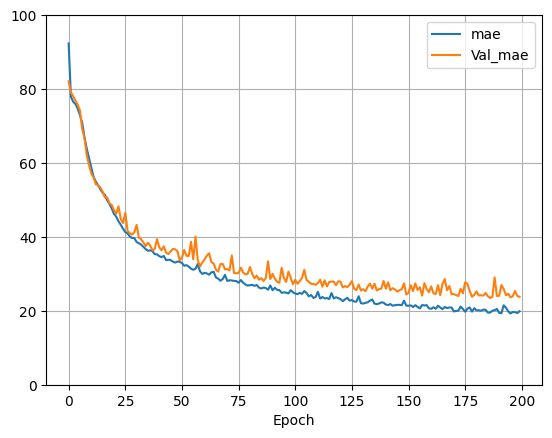

In [48]:
plot_mae(scaled_history)

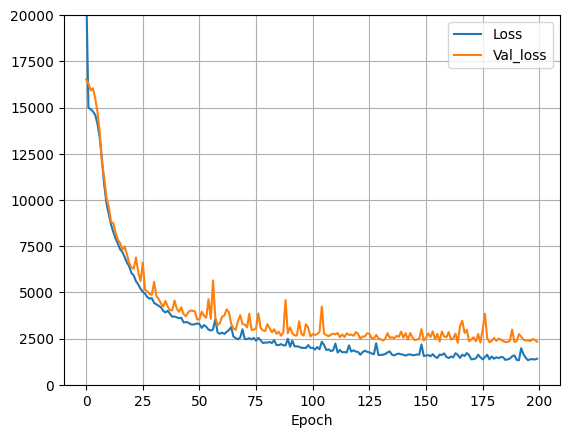

In [49]:
plot_loss(scaled_history)

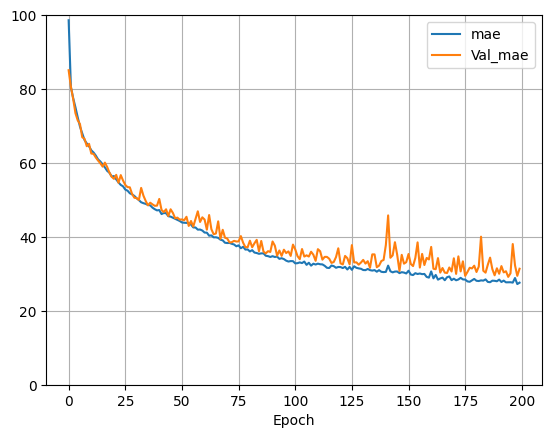

In [50]:
non_scaled = plot_mae(non_scaled_history)

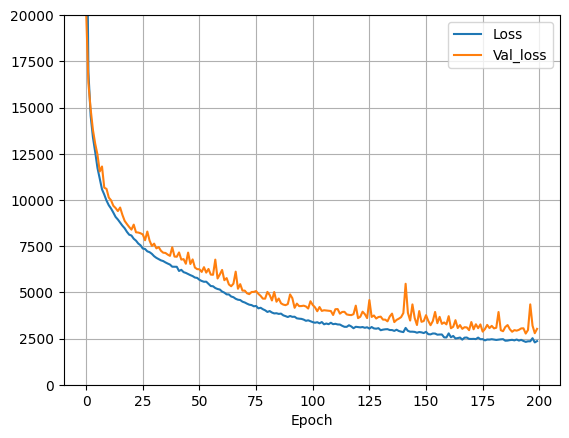

In [51]:
plot_loss(non_scaled_history)

# Zapisanie najlepszych modeli do pliku

In [32]:
best_scaled_model.save("../Models/heating_scaled_model.keras")
best_nonscaled_model.save("../Models/heating_nonscaled_model.keras")